# code to run runwise GLMs based on stimType - main analysis: Mental vs. Random, and mdoel comparison between stim-based and response-based models

- created on July 5 to address reviewer qns

In [1]:
# import general packages, check folders
#%reset
import os
import numpy as np
import h5py
import pandas as pd
#import imagesc as imagesc #pip install imagesc
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import time
from pathlib import Path

# TO DO - REMOVE THE UNNECESSARY LIBRARY IMPORTS

%matplotlib inline

working_dir = '/Users/f0053cz/Dropbox (Dartmouth College)/postdoc_Dartmouth/HCP/fMRIScipts/code'
#working_dir = os.getcwd()
print('current directory:\n',working_dir)
path = Path(working_dir)
parent_folder = path.parent
#print('parent folder:', parent_folder)
data_file_loc = os.path.join(parent_folder,'data') # to store data we extract later in this notebook

current directory:
 /Users/f0053cz/Dropbox (Dartmouth College)/postdoc_Dartmouth/HCP/fMRIScipts/code


In [2]:
# setting default fontsizes for plots

s=16 # CHANGE FONTSIZE HERE
plt.rc('font', size=s) #controls default text size
plt.rc('axes', titlesize=s) #fontsize of the title
plt.rc('axes', labelsize=s) #fontsize of the x and y labels
plt.rc('xtick', labelsize=s) #fontsize of the x tick labels
plt.rc('ytick', labelsize=s) #fontsize of the y tick labels
plt.rc('legend', fontsize=s) #fontsize of the legend
#import matplotlib as mpl
#mpl.rcParams['font.weight']= 'normal'

In [3]:
#suff= ' '
suff = '_corrected'

In [4]:
# load behavioral data - coded 1 for "social", 0 for "nonsocial" and 9 for "unsure", nan for missed response
# even if using the Mental/Random labels, need this to sub-select subs who have responded on all trials
responses = np.load(os.path.join(data_file_loc,f'responses{suff}.npy'))
responses.shape # subs *movies

(1049, 10)

In [5]:
vid_joined = ["COAXING-B", "BILLIARD-A", "DRIFTING-A", "Fishing", "Random mechanical","Scaring", "SEDUCING-B", "STAR-A", "SURPRISING-B", "TENNIS-A"]
vid_joined

['COAXING-B',
 'BILLIARD-A',
 'DRIFTING-A',
 'Fishing',
 'Random mechanical',
 'Scaring',
 'SEDUCING-B',
 'STAR-A',
 'SURPRISING-B',
 'TENNIS-A']

In [6]:
print('Nr of complete subs:',len(np.where(np.array([len(np.where(~np.isnan(responses[s,:]))[0]) for s in range(responses.shape[0])])==10)[0]))
print('total subs:', responses.shape[0])

Nr of complete subs: 814
total subs: 1049


In [7]:
timecourses = np.load(os.path.join(data_file_loc,f'timecourses{suff}.npy'))
timecourses.shape

(1049, 268, 269, 2)

In [8]:
[timepts_indiv_movie,vid_start_rel_tr] = np.load(os.path.join(data_file_loc,'Video_TRs.npy'),allow_pickle=True)
vid_start_rel_tr

array([6, 13, 13, 13, 13, 6, 13, 13, 13, 13], dtype=object)

# LME stim label vs. response label

In [9]:
vidnames = ["COAXING-B", "BILLIARD-A", "DRIFTING-A", "Fishing", "Random mechanical","Scaring", "SEDUCING-B", "STAR-A", "SURPRISING-B", "TENNIS-A"]

# creating a 3D array of beta coeffs across movies from individual movie files
all_coefs = np.zeros((responses.shape[0],268,10))

for m in range(10):
    fileName =  os.path.join(data_file_loc,'coefs_run_norm','slope_reg',f'coef_slopereg_runnorm_{vidnames[m]}{suff}.npy')
    all_coefs[:,:,m] = np.load(fileName)
    #print(dat.shape)

all_coefs[:10,0,:2]

array([[ 9.33693863e-01,  1.66709840e-01],
       [ 2.46438372e+00,  6.79413212e-01],
       [-4.82038901e-01, -6.60210885e-01],
       [ 9.71036189e-01,  1.97436306e+00],
       [-8.99258171e-01, -2.68430814e-01],
       [ 6.55118512e-01, -1.78271651e-03],
       [ 1.27985989e+00, -7.11127922e-01],
       [ 5.54624492e-01,  1.54513876e-01],
       [ 9.87224895e-01,  2.01677021e+00],
       [ 6.72424811e-02,  4.51586746e-01]])

In [10]:
# first of all, best to remove subjects with < 10 responses for power in general
count_resp = np.zeros((responses.shape[0],))
for i in range(responses.shape[0]):
    count_resp[i] = len(np.where(~np.isnan(responses[i,:]))[0])
subs_10resp = np.where(count_resp == 10)[0]
len(subs_10resp)

814

In [11]:
#install lme functions
from pymer4.models import Lmer
#from pymer4.models import Lm
import time

In [12]:
coef_ALL_stim, coef_ALL_resp = [np.empty((268,)) for _ in range(2)]
coef_ALL_stim[:], coef_ALL_resp[:] = [np.nan]*2

pval_ALL_stim, pval_ALL_resp = [np.empty((268,)) for _ in range(2)]
pval_ALL_stim[:], pval_ALL_resp[:] = [np.nan]*2

AIC_ALL_stim, AIC_ALL_resp = [np.empty((268,)) for _ in range(2)]
AIC_ALL_stim[:], AIC_ALL_resp[:] = [np.nan]*2

In [13]:
stimType = [1,0,0,1,0,1,1,0,1,0]

In [14]:
from datetime import datetime

In [15]:
# STMTYPE BASED
load_all = 0 # 1: load saved coefs, 0: run the LME
if load_all == 1:
     df_all_coefs = pd.read_csv(os.path.join(data_file_loc,'coefs_run_norm','slope_reg','LME_S_NS_revision1','lmecoefs_all_S_NS_stimType.csv'))
     #[coef_ALL_stim,pval_ALL_stim] = np.load(os.path.join(data_file_loc,'coefs_run_norm','slope_reg','LME_S_NS_revision1','lmecoefs_all_S_NS_stimType.npy'), allow_pickle=True)
else:
    start_time =  time.time()
    for n in range(268):
        if n%10 == 0:
            print(f'node {n+1},time={(time.time()-start_time)/60:.2f} mins')
        
        df = pd.DataFrame(columns = ['coefs','stimType','subID','movie'])
        for m in range(10):
            df_temp = pd.DataFrame({'coefs': all_coefs[subs_10resp,n,m],'stimType':stimType[m], 'response':responses[subs_10resp,m],'subID':subs_10resp,\
                 'movie':np.repeat(m,len(subs_10resp))})
            df = df.append(df_temp,ignore_index=True)
            df = df.loc[df['response'] != 9] # yes v no
        
        df['stimType'] = df['stimType'].map({1.0: "Mental", 0.0:  "Random"})
        df['response'] = df['response'].map({1.0: "Non-social", 0.0:  "Social"})
        
        model1 = Lmer('coefs ~  stimType +(1|subID) + (1|movie)', data=df) # ff: mean response, rf:subjID
        model1.fit(factors={"stimType":["Random","Mental"]},summary = False, verbose = False)
        model2 = Lmer('coefs ~  response +(1|subID) + (1|movie)', data=df) # ff: mean response, rf:subjID
        model2.fit(factors={"response":["Non-social","Social"]},summary = False, verbose = False)

        if n == 0:
            print('model:',model1.fit(factors={"stimType":["Random","Mental"]}))
            print('model:',model2.fit(factors={"response":["Non-social","Social"]}))

        coef_ALL_stim[n] = model1.coefs['Estimate'][1]
        pval_ALL_stim[n]= model1.coefs['P-val'][1]
        AIC_ALL_stim[n]= model1.AIC

        coef_ALL_resp[n] = model2.coefs['Estimate'][1]
        pval_ALL_resp[n]= model2.coefs['P-val'][1]
        AIC_ALL_resp[n]= model2.AIC
        
    df_all_coefs = pd.DataFrame({'Node': np.arange(268), 'coef_stim': coef_ALL_stim, 'pval_stim': pval_ALL_stim, 'AIC_stim': AIC_ALL_stim,\
        'coef_resp': coef_ALL_resp, 'pval_resp': pval_ALL_resp, 'AIC_resp': AIC_ALL_resp})
    df_all_coefs.to_csv(os.path.join(data_file_loc,'coefs_run_norm','slope_reg','LME_S_NS_revision1','lmecoefs_all_S_NS_stimType.csv'))
    #np.save(os.path.join(data_file_loc,'coefs_run_norm','slope_reg','LME_S_NS_revision1','lmecoefs_all_S_NS_stimType.npy'), [coef_ALL_stim,pval_ALL_stim])
    print('Done on/at:',datetime.now()) # cell run at)

node 1,time=0.00 mins
Formula: coefs~stimType+(1|subID)+(1|movie)

Family: gaussian	 Inference: parametric

Number of observations: 7646	 Groups: {'subID': 814.0, 'movie': 10.0}

Log-likelihood: -9539.239 	 AIC: 19078.479

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.063  0.251
movie     (Intercept)  0.005  0.068
Residual               0.661  0.813

No random effect correlations specified

Fixed effects:

model:              Estimate  2.5_ci  97.5_ci     SE    DF  T-stat  P-val  Sig
(Intercept)     0.227    0.16    0.294  0.034  9.42   6.617  0.000  ***
stimType1       0.162    0.07    0.254  0.047  8.12   3.463  0.008   **
Formula: coefs~response+(1|subID)+(1|movie)

Family: gaussian	 Inference: parametric

Number of observations: 7646	 Groups: {'subID': 814.0, 'movie': 10.0}

Log-likelihood: -9540.940 	 AIC: 19081.879

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.063  0.251
movie     (Intercept)  0.006  0.075
Residual 

<AxesSubplot:>

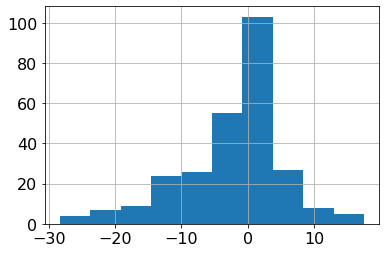

In [22]:
df_all_coefs['AIC resp-stim']= df_all_coefs['AIC_resp'] - df_all_coefs['AIC_stim']
df_all_coefs['AIC resp-stim'].hist()

# GLM analysis

In [23]:
# function needed for the GLM
from sklearn.linear_model import LinearRegression
from multiprocessing import Pool
from joblib import cpu_count
import time

Text(0.5, 0, 'Time')

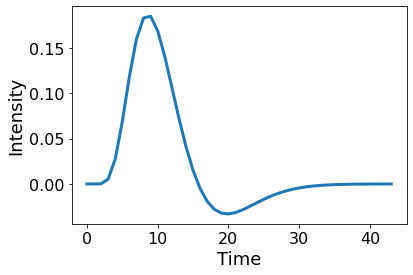

In [24]:
#defining the hrf
from nltools.external import glover_hrf
tr = .72
#hrf function
hrf = glover_hrf(tr, oversampling=1)
plt.plot(hrf, linewidth=3)
plt.ylabel('Intensity', fontsize=18)
plt.xlabel('Time', fontsize=18)

In [25]:
# functions that will be parallelized across nodes. For use in the next cell
def lm_estimate(XY):
    # function to perform a linear regression and to return the reg. coefft.
    X = XY[:int(.5*len(XY))].reshape((-1,1))
    Y = XY[int(.5*len(XY)):] 
    model = LinearRegression().fit(X, Y) 
    return model.coef_[0] 


In [26]:
l_task = 28
load = 0 # 1 = load previously saved reg coeffts for all movies, 0 = estimate coefts freshly
timepts_indiv_movie[0]

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48])

In [27]:
timecourses.shape

(1049, 268, 269, 2)

0 time: 0.06905913352966309
100 time: 6.370908260345459
200 time: 13.739320278167725
300 time: 21.446734189987183
400 time: 30.134393215179443
500 time: 38.58603501319885
600 time: 46.98448896408081
700 time: 59.1611111164093
800 time: 68.0819730758667
900 time: 75.66128635406494
1000 time: 83.6807610988617


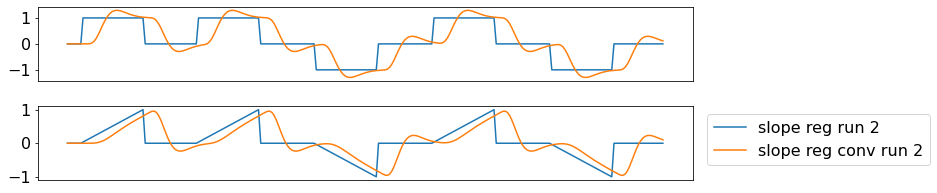

In [28]:
# Store block/slope regressors per run based on responses

if load == 0:
    coef_block = np.empty((timecourses.shape[0],268,2))
    coef_slope = np.empty_like(coef_block)
    coef_block[:] = np.nan
    coef_slope[:] = np.nan
    start = time.time()
    if __name__ == '__main__':
        pool = Pool(processes=cpu_count()) # helps to parallelize processing

        for s in range(timecourses.shape[0]):
            if s%100 ==0:
                print(s,'time:',time.time()-start) 
            if len(np.where(np.isnan(responses[s,:]))[0]) == 0: # if the subject responded to all stimuli (excluding incomeplete subs)
                for vid_no in range(10):
                    #resp = responses[s,vid_no] # response for a subject and video nr.
                    stimType_s = stimType[vid_no]
                    #inds       = timepts_indiv_movie[vid_no][vid_start_rel_tr[vid_no]:vid_start_rel_tr[vid_no]+l_task+1] # to i
                    inds_block = timepts_indiv_movie[vid_no][(vid_start_rel_tr[vid_no]+1):(vid_start_rel_tr[vid_no]+l_task+1)]
                    inds_slope = timepts_indiv_movie[vid_no][(vid_start_rel_tr[vid_no]):(vid_start_rel_tr[vid_no]+l_task+1)]
    
                    if vid_no==0:
                        boxcar_run = np.zeros((269,2)) # to store runwise block regressors
                        slope_run = np.zeros_like(boxcar_run) # to store runwise slope regressors
                    
                    r = 1 if vid_no>=5 else 0
                    if stimType_s == 1: #resp == 1:
                        boxcar_run[inds_block,r] = 1 
                        slope_run[inds_slope,r] = np.linspace(0,1,len(inds_slope)) 
                    
                    elif stimType_s == 0: #resp == 0:
                        boxcar_run[inds_block,r] = -1
                        slope_run[inds_slope,r] = -1*np.linspace(0,1,len(inds_slope))
                    
                    if (s==1) and (vid_no ==9):
                        plt.figure(1,figsize=(10,3))
                        plt.subplot(211)
                        plt.plot(boxcar_run[:,r], label = 'block reg run 2')
                        plt.xticks([])
                        plt.subplot(212)
                        plt.plot(slope_run[:,r], label = 'slope reg run 2')
                        plt.xticks([])
                        plt.tight_layout()

                #for node in range(268):
                for r in range(2):

                    boxcar_run[:,r] = np.convolve(boxcar_run[:,r], hrf)[:len(boxcar_run[:,r])]
                    slope_run[:,r] = np.convolve(slope_run[:,r], hrf)[:len(slope_run[:,r])]

                    if (s == 1) and (r ==1):
                        plt.subplot(211)
                        plt.plot(boxcar_run[:,r], label = 'block reg conv run 2')
                        plt.subplot(212)
                        plt.plot(slope_run[:,r], label = 'slope reg conv run 2')
   
                    #Y = timecourses[s,node,:,r]
                    Y = timecourses[s,:,:,r] # nodes * ntimepts
                    
                    XY = np.hstack((np.tile(boxcar_run[:,r],(268,1)),Y))
                    #print(XY)
                    XY = [i for i in XY]
                    #X = boxcar_run[:,r].reshape((-1, 1))
                    coef_block[s,:,r] = pool.map(lm_estimate,XY)

                    XY = np.hstack((np.tile(slope_run[:,r],(268,1)),Y))
                    XY = [i for i in XY]
                    coef_slope[s,:,r] = pool.map(lm_estimate,XY)
    
    fileName = os.path.join(data_file_loc,f'coef_blockreg_all{suff}_MentalRandom.npy')
    np.save(fileName,coef_block)
    fileName = os.path.join(data_file_loc,f'coef_slopereg_all{suff}_MentalRandom.npy')
    np.save(fileName,coef_slope)

elif load == 1:
    fileName = os.path.join(data_file_loc,f'coef_blockreg_all{suff}_MentalRandom.npy')
    coef_block = np.load(fileName)
    fileName = os.path.join(data_file_loc,f'coef_slopereg_all{suff}_MentalRandom.npy')
    coef_slope = np.load(fileName)
plt.legend(bbox_to_anchor = [1.01,1])

<AxesSubplot:>

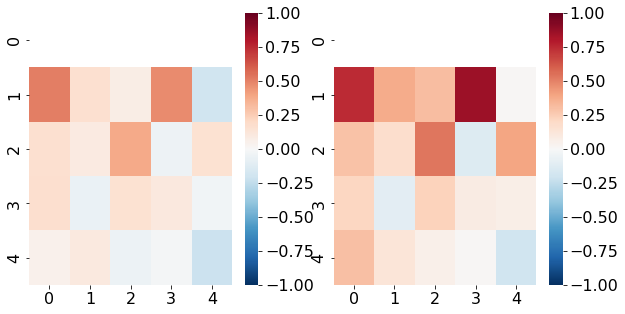

In [29]:
plt.figure(1,figsize=(10,5))
plt.subplot(121)
sns.heatmap(coef_block[:5,:5,1],vmin=-1,vmax=1,cmap='RdBu_r')
plt.subplot(122)
sns.heatmap(coef_slope[:5,:5,1],vmin=-1,vmax=1,cmap='RdBu_r')